<a href="https://colab.research.google.com/github/mphap/TrabalhoFinalGrafos/blob/main/GrafoAlgoritmoGirvanNewman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

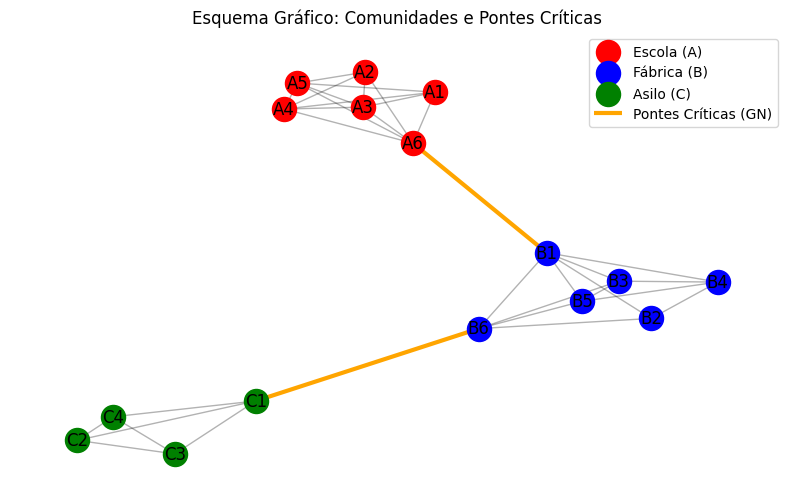

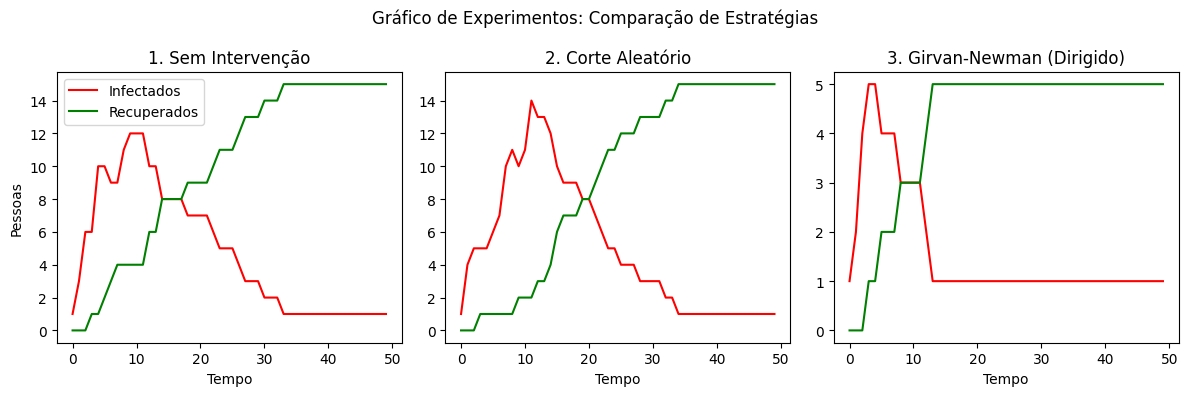

Tabela de Experimentos gerada:
                    Cenário  Pico de Infectados  Total de Afetados (R final)  \
0           Sem Intervenção                  12                           15   
1           Corte Aleatório                  14                           15   
2  Girvan-Newman (Dirigido)                   5                            5   

  Arestas Removidas  
0           Nenhuma  
1    2 (Aleatórias)  
2        2 (Pontes)  


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np


# 1. MODELAGEM DO GRAFO (ESQUEMA GRÁFICO)

def create_social_graph():
    G = nx.Graph()

    # Definindo Comunidades (Nós)
    # A: Escola (Alta densidade)
    nodes_A = [f"A{i}" for i in range(1, 7)]
    # B: Fábrica (Alta densidade)
    nodes_B = [f"B{i}" for i in range(1, 7)]
    # C: Asilo (Vulnerável, menor)
    nodes_C = [f"C{i}" for i in range(1, 5)]

    # Adicionar arestas internas (Conexão forte dentro do grupo)
    for nodes in [nodes_A, nodes_B, nodes_C]:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                if random.random() > 0.1: # 90% de chance de conexão interna
                    G.add_edge(nodes[i], nodes[j])

    # Adicionar Pontes (Conexões entre grupos)
    # Ponte A-B (Escola - Fábrica)
    G.add_edge("A6", "B1")
    # Ponte B-C (Fábrica - Asilo)
    G.add_edge("B6", "C1")

    return G, nodes_A, nodes_B, nodes_C


# 2. SIMULAÇÃO SIR

def run_sir(G, initial_node, beta=0.4, gamma=0.1, steps=50):
    # Estados: S, I, R
    status = {n: 'S' for n in G.nodes()}
    status[initial_node] = 'I'

    history = {'S': [], 'I': [], 'R': []}

    for _ in range(steps):
        history['S'].append(list(status.values()).count('S'))
        history['I'].append(list(status.values()).count('I'))
        history['R'].append(list(status.values()).count('R'))

        new_status = status.copy()
        for n in G.nodes():
            if status[n] == 'I':
                # Recuperação
                if random.random() < gamma:
                    new_status[n] = 'R'
                # Infecção de vizinhos
                for neighbor in G.neighbors(n):
                    if status[neighbor] == 'S':
                        if random.random() < beta:
                            new_status[neighbor] = 'I'
        status = new_status

        if list(status.values()).count('I') == 0:
            break # Fim da epidemia

    # Preencher restante dos passos com o último estado
    while len(history['S']) < steps:
        history['S'].append(history['S'][-1])
        history['I'].append(history['I'][-1])
        history['R'].append(history['R'][-1])

    return history


# 3. EXPERIMENTOS E GIRVAN-NEWMAN

G, comA, comB, comC = create_social_graph()
seed_node = "A1" # Infecção começa na escola

# Cenário 1: Sem Intervenção
hist_base = run_sir(G, seed_node)

# Cenário 2: Corte Aleatório (Remove 2 arestas quaisquer)
G_rand = G.copy()
edges = list(G_rand.edges())
if len(edges) > 2:
    rem_rand = random.sample(edges, 2)
    G_rand.remove_edges_from(rem_rand)
hist_rand = run_sir(G_rand, seed_node)

# Cenário 3: Corte Dirigido (Girvan-Newman - Remove pontes por betweenness)
G_gn = G.copy()
centrality = nx.edge_betweenness_centrality(G_gn)
# Ordenar arestas pela centralidade (maior para menor)
sorted_edges = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
# Remover as 2 arestas com maior betweenness (Top 2 pontes)
bridges_to_remove = [edge[0] for edge in sorted_edges[:2]]
G_gn.remove_edges_from(bridges_to_remove)
hist_gn = run_sir(G_gn, seed_node)

# 4. GERAÇÃO DOS RESULTADOS VISUAIS


# A) ESQUEMA GRÁFICO (Visualização da Rede)
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
# Desenhar nós por comunidade
nx.draw_networkx_nodes(G, pos, nodelist=comA, node_color='r', label='Escola (A)')
nx.draw_networkx_nodes(G, pos, nodelist=comB, node_color='b', label='Fábrica (B)')
nx.draw_networkx_nodes(G, pos, nodelist=comC, node_color='g', label='Asilo (C)')
# Desenhar arestas normais
nx.draw_networkx_edges(G, pos, alpha=0.3)
# Destacar pontes detectadas pelo Girvan-Newman
nx.draw_networkx_edges(G, pos, edgelist=bridges_to_remove, edge_color='orange', width=3, label='Pontes Críticas (GN)')
nx.draw_networkx_labels(G, pos)
plt.title("Esquema Gráfico: Comunidades e Pontes Críticas")
plt.legend()
plt.axis('off')
plt.savefig('esquema_grafico.png')
plt.show()

# B) GRÁFICO DE EXPERIMENTOS (Curvas SIR)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(hist_base['I'], color='red', label='Infectados')
plt.plot(hist_base['R'], color='green', label='Recuperados')
plt.title("1. Sem Intervenção")
plt.xlabel("Tempo")
plt.ylabel("Pessoas")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hist_rand['I'], color='red')
plt.plot(hist_rand['R'], color='green')
plt.title("2. Corte Aleatório")
plt.xlabel("Tempo")

plt.subplot(1, 3, 3)
plt.plot(hist_gn['I'], color='red')
plt.plot(hist_gn['R'], color='green')
plt.title("3. Girvan-Newman (Dirigido)")
plt.xlabel("Tempo")

plt.suptitle("Gráfico de Experimentos: Comparação de Estratégias")
plt.tight_layout()
plt.savefig('grafico_experimentos.png')
plt.show()

# C) TABELA DE EXPERIMENTOS
results = {
    "Cenário": ["Sem Intervenção", "Corte Aleatório", "Girvan-Newman (Dirigido)"],
    "Pico de Infectados": [max(hist_base['I']), max(hist_rand['I']), max(hist_gn['I'])],
    "Total de Afetados (R final)": [hist_base['R'][-1], hist_rand['R'][-1], hist_gn['R'][-1]],
    "Arestas Removidas": ["Nenhuma", f"{len(rem_rand)} (Aleatórias)", f"{len(bridges_to_remove)} (Pontes)"]
}
df = pd.DataFrame(results)

# Exibir tabela e salvar como CSV para o artigo
print("Tabela de Experimentos gerada:")
print(df)
df.to_csv('tabela_experimentos.csv', index=False)